### テストデータを用意して、部分時系列の取り方によるトレンド推定の違いを確認
---

日経平均でやってもあまり差が出なかったため、  
差が出そうなテストデータを作って再トライ

In [1]:
import random

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline

import statsmodels.api as sm

#### テストデータを生成

In [38]:
random.seed(345)
np.random.seed(345)

# 変化する過程誤差を生成
noise_1 = np.random.normal(0, 1, 200)
noise_2 = np.random.normal(0, 5, 200) # 途中で分散が変わる
noise = np.concatenate([noise_1, noise_2])

# 観測誤差を生成
obs_noise = np.random.normal(0, 5, 400)

# 変化するトレンド
trend_1 = np.empty(100)
trend_2 = np.empty(100)
trend_3 = np.empty(100)
trend_4 = np.empty(100)
for i in range(0, 100):
    trend_1[i] = 0
    trend_2[i] = 0.8
    trend_3[i] = 0.8
    trend_4[i] = 0.2
trend = np.concatenate([trend_1, trend_2, trend_3, trend_4])

In [39]:
# 真の状態
y_true = np.empty(400)
y = np.empty(400)
y_true[0] = 100
y[0] = 100

for i in range(0, 399):
    y_true[i+1] = y_true[i] + trend[i] + noise[i]
    y[i+1] = y_true[i+1] + obs_noise[i]

#### とりあえずプロット
---

それっぽいトレンドが見える

Text(0.5, 1.0, 'y_kansoku')

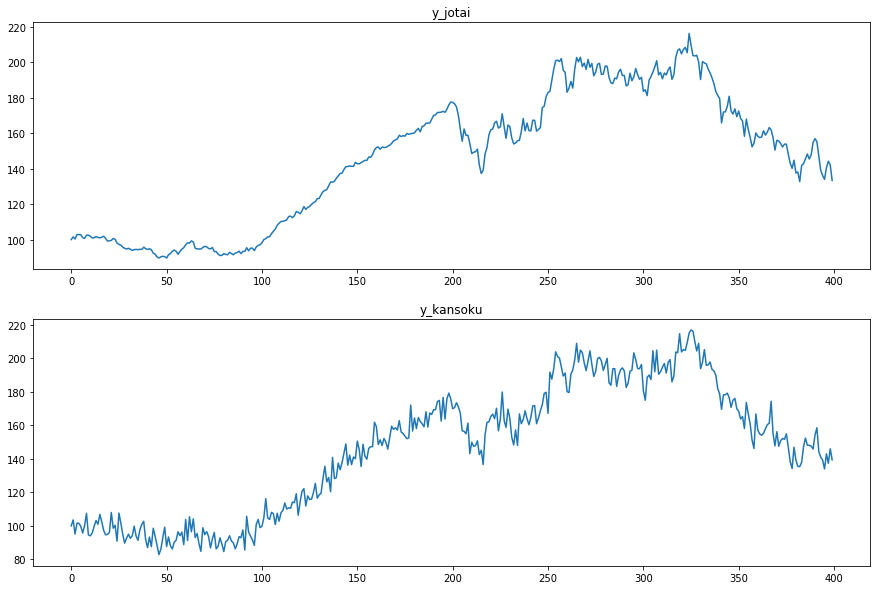

In [40]:
rcParams['figure.figsize'] = 15, 10
fig, axes = plt.subplots(2, 1)
axes[0].plot(y_true)
axes[0].set_title("y_jotai")
axes[1].plot(y)
axes[1].set_title("y_kansoku")

#### データをセット

In [41]:
date_index = pd.date_range(start='1/1/2017', periods=400,  freq='D')

In [42]:
df = pd.DataFrame()
df['Date'] = date_index
df['y'] = y
df = df.set_index(keys='Date', drop=True)
ts = df['y'] 

#### ローカル線形トレンドモデル（カルマンフィルタ）
---

c:\users\bell\desktop\python\anomaly\py36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 3.302479
         Iterations: 29
         Function evaluations: 49
         Gradient evaluations: 49
                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  400
Model:             local linear trend   Log Likelihood               -1320.991
Date:                Thu, 14 Mar 2019   AIC                           2647.983
Time:                        01:04:29   BIC                           2659.942
Sample:                    01-01-2017   HQIC                          2652.720
                         - 02-04-2018                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    22.462

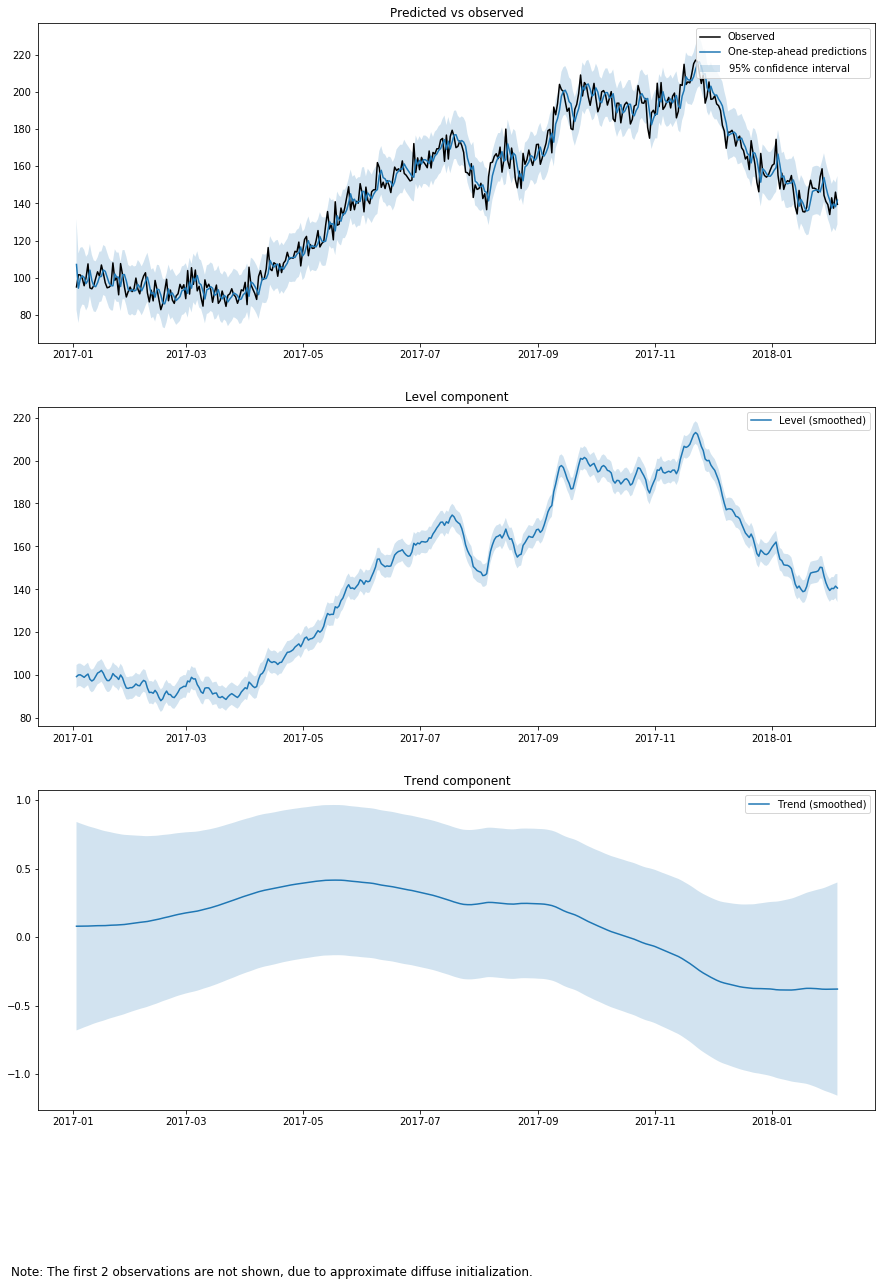

In [43]:
# ローカル線形トレンドモデル
model = sm.tsa.UnobservedComponents(
    ts,
    'local linear trend'
)

# パラメータの推定
res = model.fit(method='bfgs')

# 推定値を表示
print(res.summary())

# 推定値を表示
rcParams['figure.figsize'] = 15, 20
fig = res.plot_components()

#### 最初の200時点を捨て、期間を絞る
---

最初の山を無くせば、結果が少し変わるかも？

In [44]:
ts_2 = ts[200:]

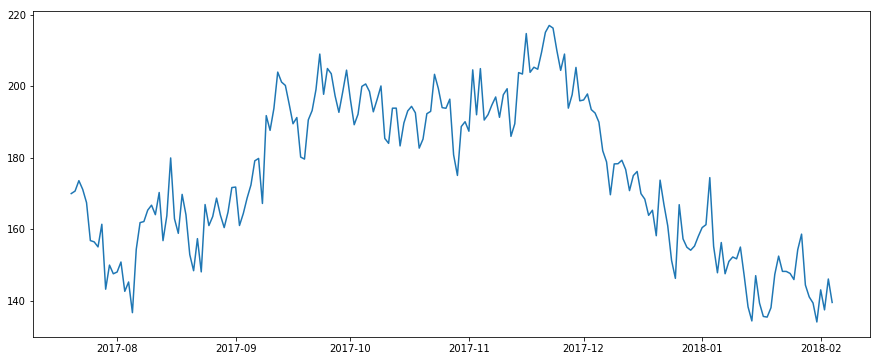

In [45]:
rcParams['figure.figsize'] = 15, 6
plt.plot(ts_2)

#### ローカル線形トレンドモデル（部分時系列版）

c:\users\bell\desktop\python\anomaly\py36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 3.383954
         Iterations: 24
         Function evaluations: 48
         Gradient evaluations: 48
                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  200
Model:             local linear trend   Log Likelihood                -676.791
Date:                Thu, 14 Mar 2019   AIC                           1359.582
Time:                        01:04:37   BIC                           1369.446
Sample:                    07-20-2017   HQIC                          1363.575
                         - 02-04-2018                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    19.926

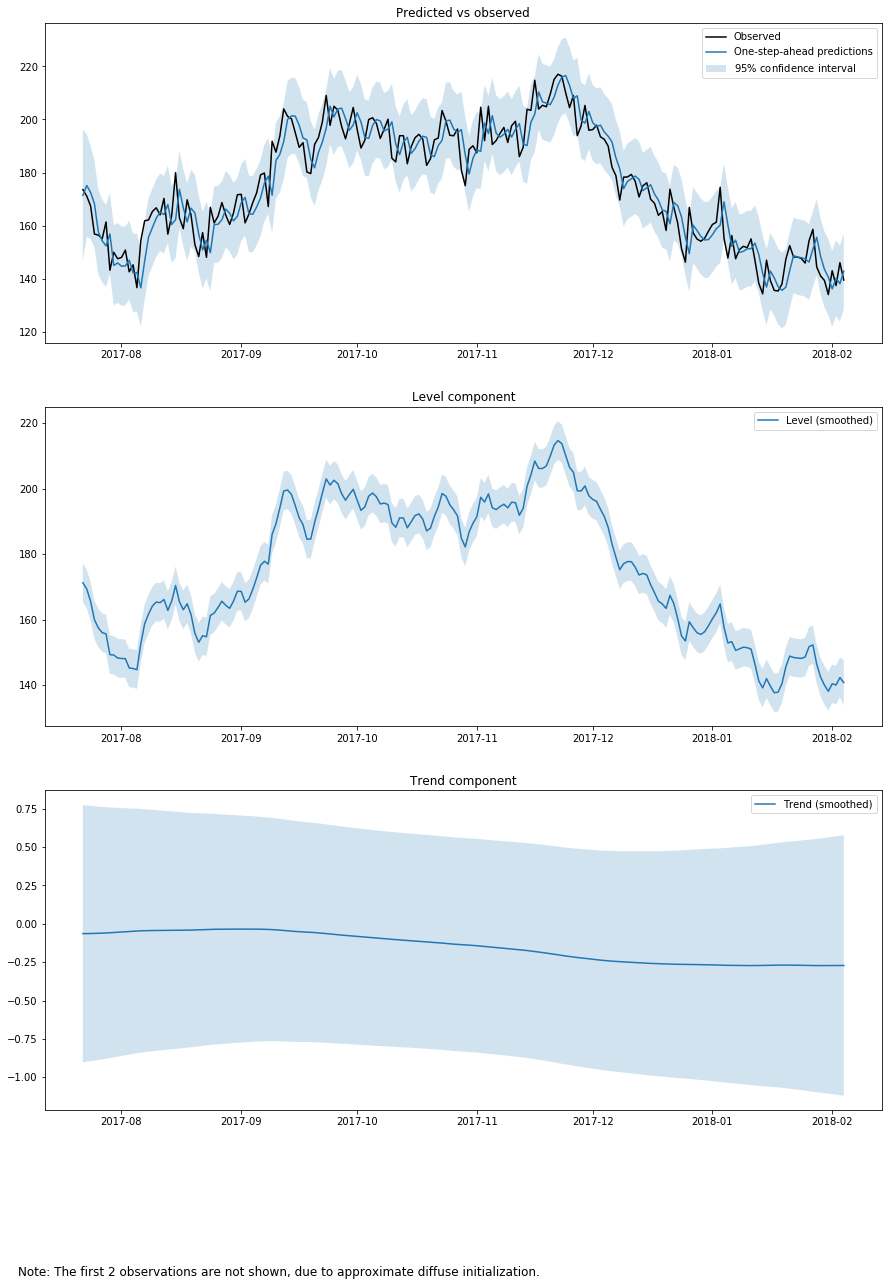

In [46]:
# ローカル線形トレンドモデル
model_2 = sm.tsa.UnobservedComponents(
    ts_2,
    'local linear trend'
)

# パラメータの推定
res_2 = model_2.fit(method='bfgs')

# 推定値を表示
print(res_2.summary())

# 推定値を表示
rcParams['figure.figsize'] = 15, 20
fig = res_2.plot_components()

#### トレンド項を比較する

In [47]:
pad = np.zeros(200)
pad[:] = np.nan

In [48]:
# 長さが違うので、足りない分だけ期間絞った版を0埋めして整形
graph = pd.DataFrame()
graph['Date'] = df.index
graph['all_term_trend'] = res.trend.smoothed
graph['p_term_trend'] = np.concatenate([pad, res_2.trend.smoothed])
graph = graph.set_index(keys='Date', drop=True)

#### 学習データに用いた期間の違いによって、推定値がずれてる
---

どちらも、なんとなく推定されてそう  
部分時系列の取り方次第で、推定結果が変わっている

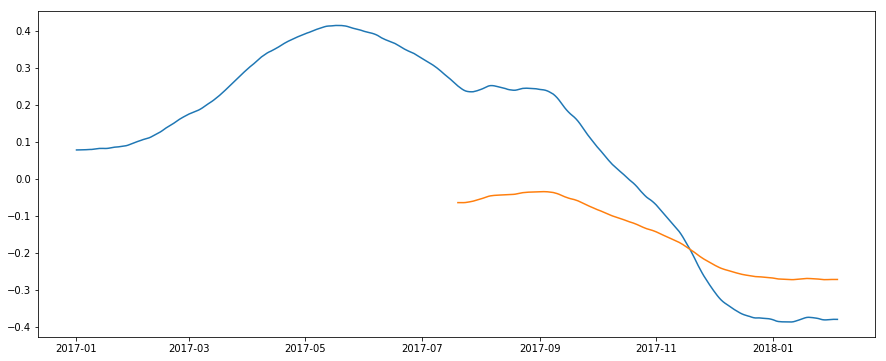

In [49]:
rcParams['figure.figsize'] = 15, 6
plt.plot(graph)